<a href="https://colab.research.google.com/github/Murad-pitafi/Computer-Vision/blob/main/Image_Reconstruction_and_Noise_Removal_with_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.34MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
num_epochs = 10
for epoch in range(num_epochs):
    for data, _ in train_loader:
        data = data.to(device)
        output = model(data)
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


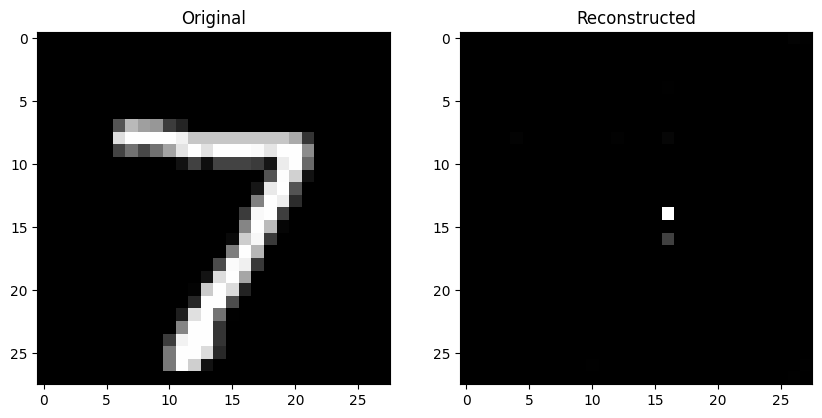

In [6]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output = model(data)
        break

data, output = data.cpu(), output.cpu()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(data[0].squeeze(), cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(output[0].squeeze(), cmap='gray')
axes[1].set_title('Reconstructed')
plt.show()


In [7]:
def add_noise(imgs):
    noise = torch.randn_like(imgs) * 0.5
    noisy_imgs = imgs + noise
    return torch.clamp(noisy_imgs, 0., 1.)

noisy_data = add_noise(data)


In [8]:
model.eval()
with torch.no_grad():
    denoised_output = model(noisy_data.to(device)).cpu()


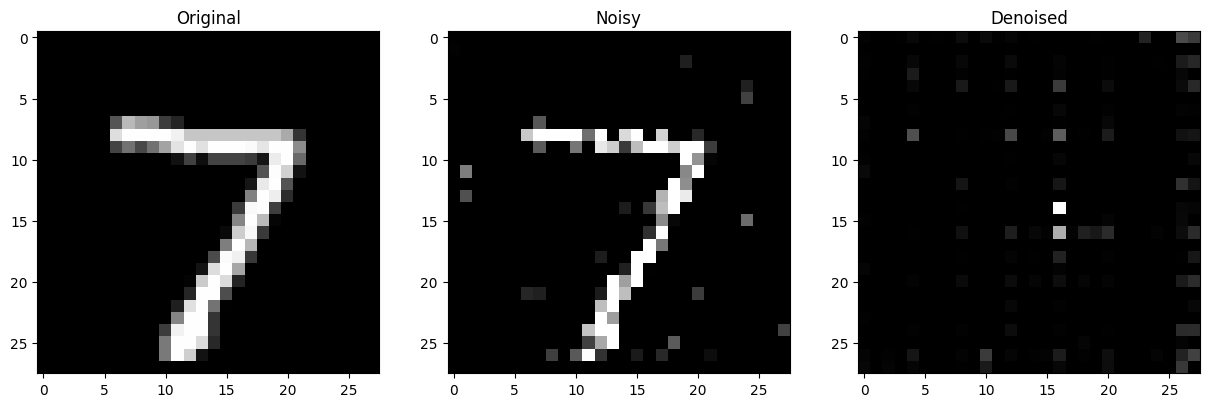

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(data[0].squeeze(), cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(noisy_data[0].squeeze(), cmap='gray')
axes[1].set_title('Noisy')
axes[2].imshow(denoised_output[0].squeeze(), cmap='gray')
axes[2].set_title('Denoised')
plt.show()
